# 📊 Análisis Exploratorio: Limpieza de Datos

## 🎯 Objetivo
Este notebook analiza el dataset crudo de bicicletas públicas de Buenos Aires para **analizar las decisiones de limpieza** que implementamos en `src/utils.py`.

### 🔍 Decisiones a Analizar:
1. **Duración mínima**: Eliminar recorridos < 60 segundos
2. **Rango temporal**: Filtrar datos antes de cierta fecha  
3. **Edades válidas**: Usuarios entre 10-100 años
4. **Coordenadas válidas**: Estaciones con lat/lng válidas
5. **IDs válidos**: Eliminar registros con IDs faltantes

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("📚 Librerías cargadas correctamente")
print(f"📅 Análisis ejecutado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


📚 Librerías cargadas correctamente
📅 Análisis ejecutado: 2025-07-02 01:02:26


In [2]:
# Cargar datos crudos (sin limpieza)
print("🔄 Cargando datos crudos...")

# Función para cargar sin limpieza
def load_raw_data(path):
    try:
        df = pd.read_csv(path, parse_dates=['fecha_origen_recorrido', 'fecha_destino_recorrido'], low_memory=False)
        print(f"✅ {path}: {len(df):,} registros")
        return df
    except Exception as e:
        print(f"❌ Error cargando {path}: {e}")
        return None

# Intentar cargar diferentes años
datasets = {}
for year in [2020, 2021, 2022, 2023, 2024]:
    df = load_raw_data(f'data/raw/trips_{year}.csv')
    if df is not None:
        datasets[year] = df

print(f"\n📊 Datasets cargados: {len(datasets)} años")
total_records = sum(len(df) for df in datasets.values())
print(f"📈 Total registros crudos: {total_records:,}")


🔄 Cargando datos crudos...
✅ data/raw/trips_2020.csv: 2,415,597 registros
✅ data/raw/trips_2021.csv: 2,860,091 registros
✅ data/raw/trips_2022.csv: 2,922,805 registros
✅ data/raw/trips_2023.csv: 2,622,331 registros
✅ data/raw/trips_2024.csv: 3,559,284 registros

📊 Datasets cargados: 5 años
📈 Total registros crudos: 14,380,108


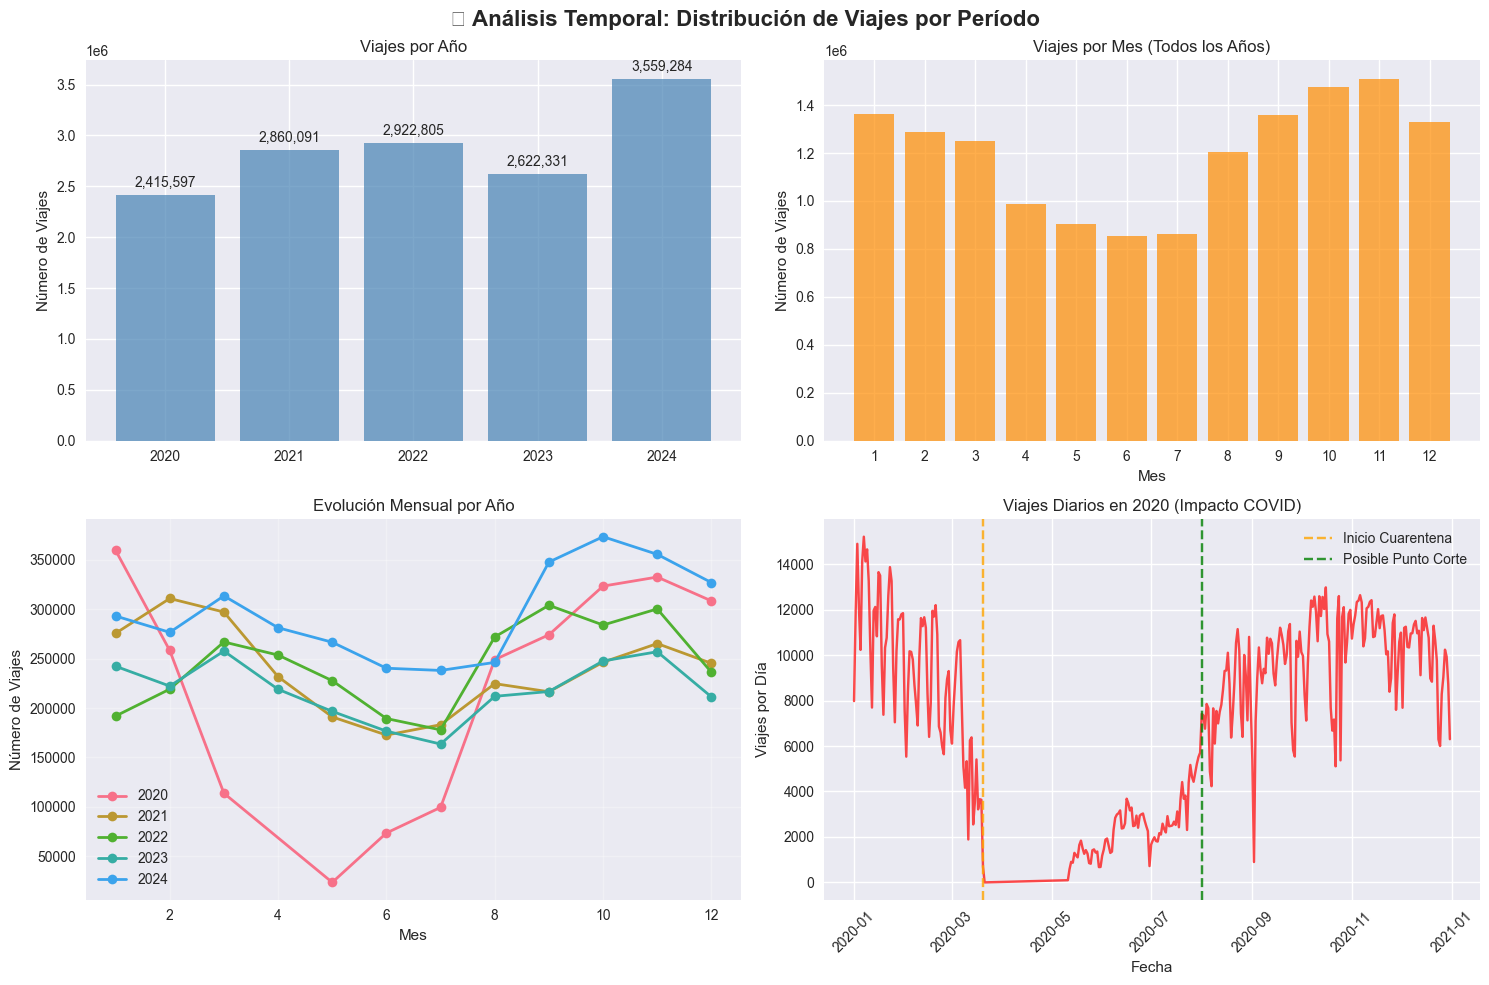


📊 CONCLUSIONES TEMPORALES:
• Total de viajes: 14,380,108
• Año con más viajes: 2024 (3,559,284 viajes)
• Mes con más viajes: 11 (1,510,600 viajes)

🔍 ANÁLISIS 2020:
• Viajes antes de agosto 2020: 928,136 (38.4%)
• Viajes después de agosto 2020: 1,487,461 (61.6%)
• Promedio diario pre-agosto: 4357 viajes/día
• Promedio diario post-agosto: 9722 viajes/día


In [4]:
# Análisis temporal por año y mes
if datasets:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('📅 Análisis Temporal: Distribución de Viajes por Período', fontsize=16, fontweight='bold')
    
    # 1. Viajes por año
    yearly_counts = {year: len(df) for year, df in datasets.items()}
    axes[0,0].bar(yearly_counts.keys(), yearly_counts.values(), color='steelblue', alpha=0.7)
    axes[0,0].set_title('Viajes por Año')
    axes[0,0].set_ylabel('Número de Viajes')
    for i, (year, count) in enumerate(yearly_counts.items()):
        axes[0,0].text(year, count + 50000, f'{count:,}', ha='center', va='bottom')
    
    # 2. Viajes por mes (todos los años combinados)
    all_data = pd.concat(datasets.values(), ignore_index=True)
    all_data['mes'] = all_data['fecha_origen_recorrido'].dt.month
    monthly_counts = all_data['mes'].value_counts().sort_index()
    
    axes[0,1].bar(monthly_counts.index, monthly_counts.values, color='darkorange', alpha=0.7)
    axes[0,1].set_title('Viajes por Mes (Todos los Años)')
    axes[0,1].set_xlabel('Mes')
    axes[0,1].set_ylabel('Número de Viajes')
    axes[0,1].set_xticks(range(1, 13))
    
    # 3. Evolución mensual por año
    for year, df in datasets.items():
        df['mes'] = df['fecha_origen_recorrido'].dt.month
        monthly = df['mes'].value_counts().sort_index()
        axes[1,0].plot(monthly.index, monthly.values, marker='o', label=f'{year}', linewidth=2)
    
    axes[1,0].set_title('Evolución Mensual por Año')
    axes[1,0].set_xlabel('Mes')
    axes[1,0].set_ylabel('Número de Viajes')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Análisis específico 2020 (COVID impact)
    if 2020 in datasets:
        df_2020 = datasets[2020].copy()
        df_2020['fecha'] = df_2020['fecha_origen_recorrido'].dt.date
        daily_2020 = df_2020.groupby('fecha').size()
        
        axes[1,1].plot(daily_2020.index, daily_2020.values, color='red', alpha=0.7)
        axes[1,1].set_title('Viajes Diarios en 2020 (Impacto COVID)')
        axes[1,1].set_xlabel('Fecha')
        axes[1,1].set_ylabel('Viajes por Día')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # Marcar períodos importantes
        axes[1,1].axvline(pd.to_datetime('2020-03-20').date(), color='orange', linestyle='--', alpha=0.8, label='Inicio Cuarentena')
        axes[1,1].axvline(pd.to_datetime('2020-08-01').date(), color='green', linestyle='--', alpha=0.8, label='Posible Punto Corte')
        axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas clave
    print("\n📊 CONCLUSIONES TEMPORALES:")
    print(f"• Total de viajes: {len(all_data):,}")
    print(f"• Año con más viajes: {max(yearly_counts, key=yearly_counts.get)} ({max(yearly_counts.values()):,} viajes)")
    print(f"• Mes con más viajes: {monthly_counts.idxmax()} ({monthly_counts.max():,} viajes)")
    
    if 2020 in datasets:
        pre_aug = df_2020[df_2020['fecha_origen_recorrido'] < '2020-08-01']
        post_aug = df_2020[df_2020['fecha_origen_recorrido'] >= '2020-08-01']
        print(f"\n🔍 ANÁLISIS 2020:")
        print(f"• Viajes antes de agosto 2020: {len(pre_aug):,} ({len(pre_aug)/len(df_2020)*100:.1f}%)")
        print(f"• Viajes después de agosto 2020: {len(post_aug):,} ({len(post_aug)/len(df_2020)*100:.1f}%)")
        print(f"• Promedio diario pre-agosto: {len(pre_aug)/213:.0f} viajes/día")
        print(f"• Promedio diario post-agosto: {len(post_aug)/153:.0f} viajes/día")


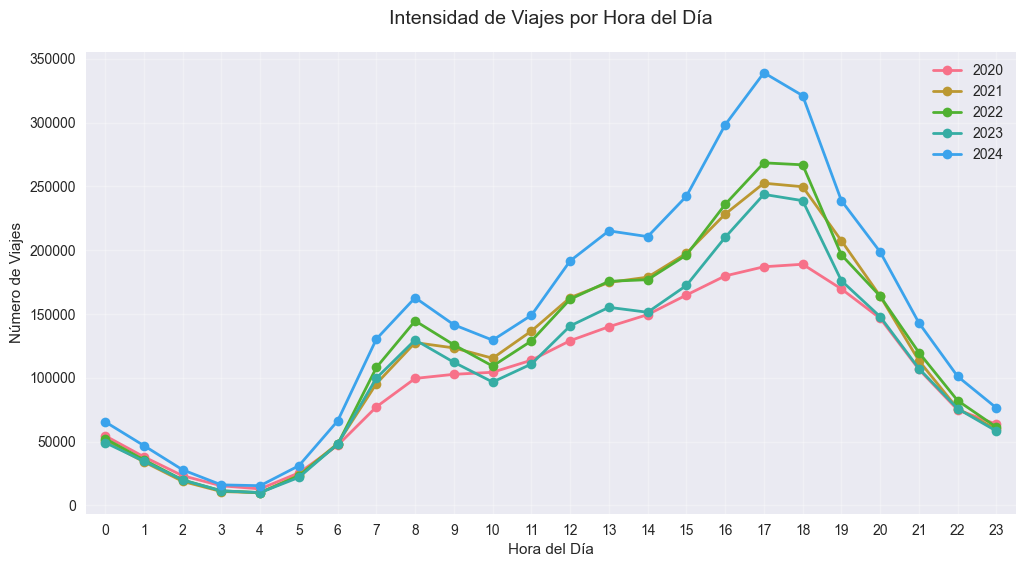


⏰ ANÁLISIS POR HORA:
• Hora pico: 17:00 (1,291,124 viajes)
• Distribución por períodos:
  - Mañana (6-12h): 22.5%
  - Tarde (12-18h): 41.2%
  - Noche (18-24h): 30.6%
  - Madrugada (0-6h): 5.7%


In [5]:
# Análisis de intensidad de viajes por hora del día
plt.figure(figsize=(12, 6))

# Extraer la hora de los viajes
for year, df in datasets.items():
    df['hora'] = df['fecha_origen_recorrido'].dt.hour
    hourly = df['hora'].value_counts().sort_index()
    
    plt.plot(hourly.index, hourly.values, marker='o', label=f'{year}', linewidth=2)

plt.title('Intensidad de Viajes por Hora del Día', fontsize=14, pad=20)
plt.xlabel('Hora del Día')
plt.ylabel('Número de Viajes')
plt.grid(True, alpha=0.3)
plt.legend()

# Ajustar ejes
plt.xticks(range(0,24))
plt.xlim(-0.5, 23.5)

plt.show()

# Estadísticas de horas pico
print("\n⏰ ANÁLISIS POR HORA:")
all_data['hora'] = all_data['fecha_origen_recorrido'].dt.hour
hora_pico = all_data['hora'].value_counts().idxmax()
viajes_pico = all_data['hora'].value_counts().max()
print(f"• Hora pico: {hora_pico}:00 ({viajes_pico:,} viajes)")
print(f"• Distribución por períodos:")
print(f"  - Mañana (6-12h): {len(all_data[all_data['hora'].between(6,11)])/len(all_data)*100:.1f}%")
print(f"  - Tarde (12-18h): {len(all_data[all_data['hora'].between(12,17)])/len(all_data)*100:.1f}%")
print(f"  - Noche (18-24h): {len(all_data[all_data['hora'].between(18,23)])/len(all_data)*100:.1f}%")
print(f"  - Madrugada (0-6h): {len(all_data[all_data['hora'].between(0,5)])/len(all_data)*100:.1f}%")


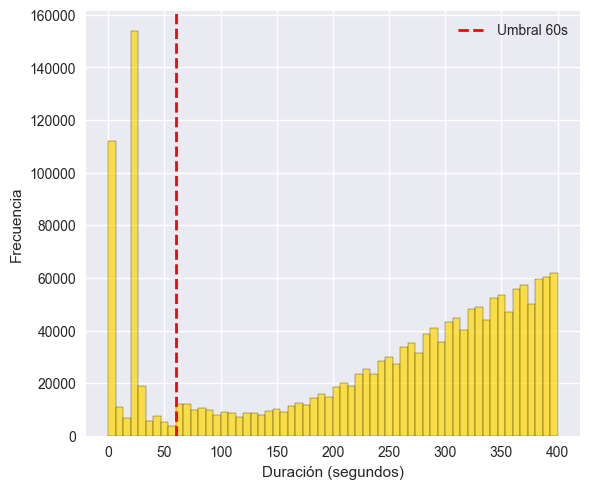


📊 ESTADÍSTICAS DE DURACIÓN:
• Total registros con duración válida: 14,380,108
• Duración mínima: 0 segundos
• Duración máxima: 19433313 segundos
• Duración promedio: 1370 segundos
• Duración mediana: 973 segundos

🔍 ANÁLISIS DE VIAJES CORTOS:
• Viajes < 60 segundos: 324,388 (2.26%)
• Viajes 60-300 segundos: 651,443 (4.53%)
• Duración promedio de viajes < 60s: 16.4 segundos

💡 JUSTIFICACIÓN UMBRAL 60s:
• Eliminar 324,388 registros sospechosos (2.26% del total)
• Recorridos < 60s probablemente son errores del sistema o cancelaciones
• Tiempo insuficiente para un viaje real en bicicleta


In [8]:
# Análisis de duración de recorridos
if datasets:
    # sample_data = pd.concat(list(datasets.values())[:2], ignore_index=True)  # Usar solo 2 años para velocidad
    
    # Convertir duración a numérico para todos los datasets
    for year, df in datasets.items():
        df['duracion_recorrido'] = pd.to_numeric(
            df['duracion_recorrido'].astype(str).str.replace(',', ''), 
            errors='coerce'
        )
    
    # Concatenar todos los datasets
    valid_duration = pd.concat(datasets.values(), ignore_index=True)
    valid_duration = valid_duration.dropna(subset=['duracion_recorrido'])

    
    # # Convertir duración a numérico
    # datasets['duracion_recorrido'] = pd.to_numeric(
    #     datasets['duracion_recorrido'].astype(str).str.replace(',', ''), 
    #     errors='coerce'
    # )
    
    # # Filtrar valores válidos
    # valid_duration = datasets.dropna(subset=['duracion_recorrido'])
    
    # 3. Zoom en duraciones cortas (0-300 segundos)
    short_trips = valid_duration[valid_duration['duracion_recorrido'] <= 400]
    fig,ax = plt.subplots(figsize=(6,5))
    ax.hist(short_trips['duracion_recorrido'], bins=60, alpha=0.7, color='gold', edgecolor='black')
    # ax.set_title('Zoom: Recorridos ≤ 5 minutos')
    ax.set_xlabel('Duración (segundos)')
    ax.set_ylabel('Frecuencia')
    ax.axvline(60, color='red', linestyle='--', linewidth=2, label='Umbral 60s')
    ax.legend()
    
    # Rotar etiquetas
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de duración
    print("\n📊 ESTADÍSTICAS DE DURACIÓN:")
    print(f"• Total registros con duración válida: {len(valid_duration):,}")
    print(f"• Duración mínima: {valid_duration['duracion_recorrido'].min():.0f} segundos")
    print(f"• Duración máxima: {valid_duration['duracion_recorrido'].max():.0f} segundos")
    print(f"• Duración promedio: {valid_duration['duracion_recorrido'].mean():.0f} segundos")
    print(f"• Duración mediana: {valid_duration['duracion_recorrido'].median():.0f} segundos")
    
    # Análisis específico de viajes muy cortos
    very_short = valid_duration[valid_duration['duracion_recorrido'] < 60]
    short_60_300 = valid_duration[(valid_duration['duracion_recorrido'] >= 60) & (valid_duration['duracion_recorrido'] < 300)]
    
    print(f"\n🔍 ANÁLISIS DE VIAJES CORTOS:")
    print(f"• Viajes < 60 segundos: {len(very_short):,} ({len(very_short)/len(valid_duration)*100:.2f}%)")
    print(f"• Viajes 60-300 segundos: {len(short_60_300):,} ({len(short_60_300)/len(valid_duration)*100:.2f}%)")
    print(f"• Duración promedio de viajes < 60s: {very_short['duracion_recorrido'].mean():.1f} segundos")
    
    print(f"\n💡 JUSTIFICACIÓN UMBRAL 60s:")
    print(f"• Eliminar {len(very_short):,} registros sospechosos ({len(very_short)/len(valid_duration)*100:.2f}% del total)")
    print(f"• Recorridos < 60s probablemente son errores del sistema o cancelaciones")
    print(f"• Tiempo insuficiente para un viaje real en bicicleta")


## 🚉 Análisis 3: Frecuencia de Uso de Estaciones

**Pregunta**: ¿Existen estaciones "fantasma" que nunca reciben ni envían bicicletas?

Este análisis identifica estaciones con muy poca o nula actividad que podrían ser eliminadas del dataset para mejorar la calidad de los modelos predictivos.


🔄 Analizando frecuencia de uso de estaciones...
📊 Analizando 5,545,136 viajes de [2022, 2023]
🚀 Estaciones de origen únicas: 373
🎯 Estaciones de destino únicas: 377

📈 ESTADÍSTICAS GENERALES:
• Total de estaciones identificadas: 377
• Estaciones con tráfico = 0: 0
• Estaciones con tráfico < 10: 5
• Estaciones con tráfico < 5000: 53
• Tráfico promedio por estación: 29417.2 viajes
• Tráfico mediano por estación: 23156.0 viajes


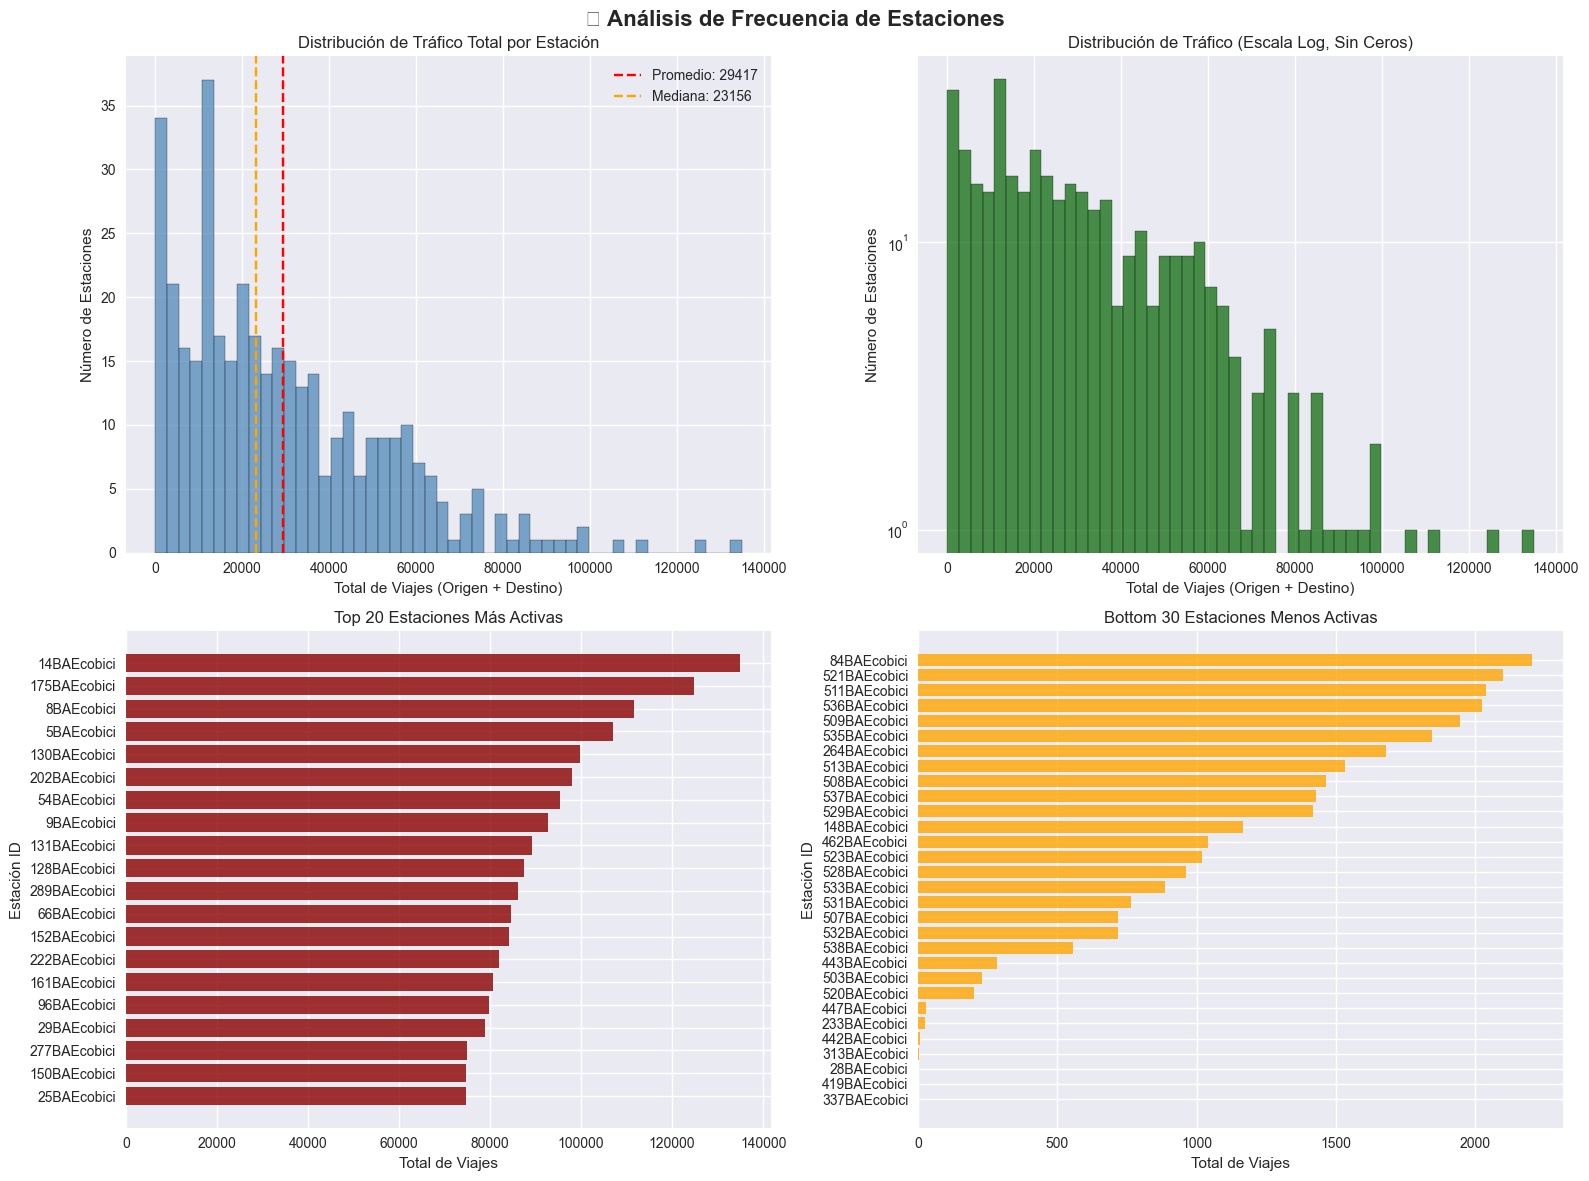

In [13]:
# Análisis de frecuencia de estaciones
print("🔄 Analizando frecuencia de uso de estaciones...")

if datasets:
    # Usar datos de 2022 y 2023 para el análisis (buen balance entre volumen y velocidad)
    sample_years = [2022, 2023]
    station_data = pd.concat([datasets[year] for year in sample_years if year in datasets], ignore_index=True)
    
    print(f"📊 Analizando {len(station_data):,} viajes de {sample_years}")
    
    # Contar viajes por estación de origen
    estaciones_origen = station_data['id_estacion_origen'].value_counts()
    print(f"🚀 Estaciones de origen únicas: {len(estaciones_origen)}")
    
    # Contar viajes por estación de destino
    estaciones_destino = station_data['id_estacion_destino'].value_counts()
    print(f"🎯 Estaciones de destino únicas: {len(estaciones_destino)}")
    
    # Combinar todas las estaciones (origen + destino) para tráfico total
    all_stations_origin = station_data['id_estacion_origen'].value_counts()
    all_stations_dest = station_data['id_estacion_destino'].value_counts()
    
    # Crear índice completo de todas las estaciones
    all_station_ids = set(all_stations_origin.index) | set(all_stations_dest.index)
    
    # Calcular tráfico total por estación (origen + destino)
    trafico_total = pd.Series(index=list(all_station_ids), dtype=int).fillna(0)
    
    for station_id in all_station_ids:
        origen_count = all_stations_origin.get(station_id, 0)
        destino_count = all_stations_dest.get(station_id, 0)
        trafico_total[station_id] = origen_count + destino_count
    
    # Ordenar por tráfico total
    trafico_total = trafico_total.sort_values(ascending=False)
    
    print(f"\n📈 ESTADÍSTICAS GENERALES:")
    print(f"• Total de estaciones identificadas: {len(trafico_total)}")
    print(f"• Estaciones con tráfico = 0: {(trafico_total == 0).sum()}")
    print(f"• Estaciones con tráfico < 10: {(trafico_total < 10).sum()}")
    print(f"• Estaciones con tráfico < 5000: {(trafico_total < 5000).sum()}")
    print(f"• Tráfico promedio por estación: {trafico_total.mean():.1f} viajes")
    print(f"• Tráfico mediano por estación: {trafico_total.median():.1f} viajes")
    
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🚉 Análisis de Frecuencia de Estaciones', fontsize=16, fontweight='bold')
    
    # 1. Distribución de tráfico total (escala normal)
    axes[0,0].hist(trafico_total, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0,0].set_title('Distribución de Tráfico Total por Estación')
    axes[0,0].set_xlabel('Total de Viajes (Origen + Destino)')
    axes[0,0].set_ylabel('Número de Estaciones')
    axes[0,0].axvline(trafico_total.mean(), color='red', linestyle='--', label=f'Promedio: {trafico_total.mean():.0f}')
    axes[0,0].axvline(trafico_total.median(), color='orange', linestyle='--', label=f'Mediana: {trafico_total.median():.0f}')
    axes[0,0].legend()
    
    # 2. Distribución en escala logarítmica
    trafico_no_zero = trafico_total[trafico_total > 0]
    axes[0,1].hist(trafico_no_zero, bins=50, alpha=0.7, color='darkgreen', edgecolor='black')
    axes[0,1].set_title('Distribución de Tráfico (Escala Log, Sin Ceros)')
    axes[0,1].set_xlabel('Total de Viajes (Origen + Destino)')
    axes[0,1].set_ylabel('Número de Estaciones')
    axes[0,1].set_yscale('log')
    
    # 3. Top 20 estaciones más activas
    top_20 = trafico_total.head(20)
    axes[1,0].barh(range(len(top_20)), top_20.values, color='darkred', alpha=0.8)
    axes[1,0].set_title('Top 20 Estaciones Más Activas')
    axes[1,0].set_xlabel('Total de Viajes')
    axes[1,0].set_ylabel('Estación ID')
    axes[1,0].set_yticks(range(len(top_20)))
    axes[1,0].set_yticklabels([str(id)[:15] + '...' if len(str(id)) > 15 else str(id) for id in top_20.index])
    axes[1,0].invert_yaxis()
    
    # 4. Estaciones con poco tráfico (bottom 30)
    bottom_30 = trafico_total.tail(30)
    axes[1,1].barh(range(len(bottom_30)), bottom_30.values, color='orange', alpha=0.8)
    axes[1,1].set_title('Bottom 30 Estaciones Menos Activas')
    axes[1,1].set_xlabel('Total de Viajes')
    axes[1,1].set_ylabel('Estación ID')
    axes[1,1].set_yticks(range(len(bottom_30)))
    axes[1,1].set_yticklabels([str(id)[:15] + '...' if len(str(id)) > 15 else str(id) for id in bottom_30.index])
    axes[1,1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No hay datos disponibles para el análisis")


In [8]:
# Análisis detallado de estaciones problemáticas
if datasets and 'trafico_total' in locals():
    print("🔍 ANÁLISIS DETALLADO DE ESTACIONES PROBLEMÁTICAS")
    print("=" * 60)
    
    # Identificar estaciones fantasma (0 viajes)
    estaciones_fantasma = trafico_total[trafico_total == 0]
    
    # Estaciones con muy poco tráfico (< 10 viajes en 2 años)
    estaciones_poco_activas = trafico_total[(trafico_total > 0) & (trafico_total < 10)]
    
    # Estaciones con tráfico bajo (< 100 viajes en 2 años)
    estaciones_trafico_bajo = trafico_total[(trafico_total >= 10) & (trafico_total < 100)]
    
    print(f"\n👻 ESTACIONES FANTASMA (0 viajes):")
    print(f"• Cantidad: {len(estaciones_fantasma)}")
    if len(estaciones_fantasma) > 0:
        print(f"• IDs: {list(estaciones_fantasma.index[:10])}{'...' if len(estaciones_fantasma) > 10 else ''}")
        print(f"• Representan {len(estaciones_fantasma)/len(trafico_total)*100:.1f}% del total de estaciones")
    
    print(f"\n⚠️ ESTACIONES POCO ACTIVAS (1-9 viajes):")
    print(f"• Cantidad: {len(estaciones_poco_activas)}")
    if len(estaciones_poco_activas) > 0:
        print(f"• Promedio de viajes: {estaciones_poco_activas.mean():.1f}")
        print(f"• Representan {len(estaciones_poco_activas)/len(trafico_total)*100:.1f}% del total de estaciones")
        print(f"• Ejemplos: {dict(estaciones_poco_activas.head(5))}")
    
    print(f"\n🔸 ESTACIONES TRÁFICO BAJO (10-99 viajes):")
    print(f"• Cantidad: {len(estaciones_trafico_bajo)}")
    if len(estaciones_trafico_bajo) > 0:
        print(f"• Promedio de viajes: {estaciones_trafico_bajo.mean():.1f}")
        print(f"• Representan {len(estaciones_trafico_bajo)/len(trafico_total)*100:.1f}% del total de estaciones")
    
    # Análisis de percentiles
    print(f"\n📊 ANÁLISIS DE PERCENTILES DE TRÁFICO:")
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        valor = np.percentile(trafico_total, p)
        print(f"• P{p}: {valor:.0f} viajes")
    
    # Top y bottom estaciones
    print(f"\n🏆 TOP 10 ESTACIONES MÁS ACTIVAS:")
    for i, (station_id, count) in enumerate(trafico_total.head(10).items(), 1):
        print(f"  {i:2d}. {station_id}: {count:,} viajes")
    
    print(f"\n🔻 BOTTOM 10 ESTACIONES (Excluyendo fantasma):")
    bottom_non_zero = trafico_total[trafico_total > 0].tail(10)
    for i, (station_id, count) in enumerate(bottom_non_zero.items(), 1):
        print(f"  {i:2d}. {station_id}: {count} viajes")
    
    # Análisis geográfico básico si hay coordenadas
    print(f"\n🗺️ ANÁLISIS DE DISTRIBUCIÓN GEOGRÁFICA:")
    
    # Obtener coordenadas de las estaciones más y menos activas
    top_5_stations = trafico_total.head(5).index
    bottom_5_stations = trafico_total[trafico_total > 0].tail(5).index
    
    print(f"• Top 5 estaciones más activas: {list(top_5_stations)}")
    print(f"• Bottom 5 estaciones activas: {list(bottom_5_stations)}")
    
    # Recomendaciones para limpieza
    print(f"\n💡 RECOMENDACIONES PARA LIMPIEZA DE DATOS:")
    print(f"=" * 50)
    
    total_problematicas = len(estaciones_fantasma) + len(estaciones_poco_activas)
    porcentaje_problematicas = total_problematicas / len(trafico_total) * 100
    
    print(f"✅ ELIMINAR estaciones fantasma ({len(estaciones_fantasma)} estaciones)")
    print(f"   → Impacto: 0% de pérdida de viajes (no tienen actividad)")
    print(f"   → Beneficio: Reducir ruido en modelos predictivos")
    
    print(f"\n⚠️ CONSIDERAR eliminar estaciones poco activas ({len(estaciones_poco_activas)} estaciones)")
    viajes_perdidos = estaciones_poco_activas.sum()
    total_viajes = len(station_data)
    print(f"   → Impacto: {viajes_perdidos:,} viajes perdidos ({viajes_perdidos/total_viajes*100:.3f}%)")
    print(f"   → Beneficio: Eliminar outliers que pueden afectar predicciones")
    
    print(f"\n🔍 INVESTIGAR estaciones con tráfico bajo ({len(estaciones_trafico_bajo)} estaciones)")
    print(f"   → Pueden ser estaciones temporales, en construcción o problemáticas")
    print(f"   → Revisar si tienen patrones estacionales o están ubicadas en zonas específicas")
    
    # Guardar listado de estaciones problemáticas para referencia
    print(f"\n💾 RESUMEN PARA IMPLEMENTACIÓN:")
    print(f"• Total estaciones problemáticas: {total_problematicas} ({porcentaje_problematicas:.1f}%)")
    print(f"• Umbral sugerido: Eliminar estaciones con < 10 viajes en 2 años")
    print(f"• Estaciones a eliminar: {len(estaciones_fantasma) + len(estaciones_poco_activas)}")
    print(f"• Impacto en viajes: {viajes_perdidos:,} viajes ({viajes_perdidos/total_viajes*100:.3f}%)")
    
    # Crear lista de estaciones a eliminar
    estaciones_a_eliminar = list(estaciones_fantasma.index) + list(estaciones_poco_activas.index)
    print(f"\n📋 Lista de {len(estaciones_a_eliminar)} estaciones candidatas para eliminación:")
    print(f"   {estaciones_a_eliminar[:20]}{'...' if len(estaciones_a_eliminar) > 20 else ''}")
    
    print(f"\n✨ Esta información puede usarse para actualizar la función de limpieza en src/utils.py")


🔍 ANÁLISIS DETALLADO DE ESTACIONES PROBLEMÁTICAS

👻 ESTACIONES FANTASMA (0 viajes):
• Cantidad: 0

⚠️ ESTACIONES POCO ACTIVAS (1-9 viajes):
• Cantidad: 5
• Promedio de viajes: 2.0
• Representan 1.3% del total de estaciones
• Ejemplos: {'442BAEcobici': np.float64(5.0), '313BAEcobici': np.float64(2.0), '28BAEcobici': np.float64(1.0), '419BAEcobici': np.float64(1.0), '337BAEcobici': np.float64(1.0)}

🔸 ESTACIONES TRÁFICO BAJO (10-99 viajes):
• Cantidad: 2
• Promedio de viajes: 27.0
• Representan 0.5% del total de estaciones

📊 ANÁLISIS DE PERCENTILES DE TRÁFICO:
• P1: 4 viajes
• P5: 1368 viajes
• P10: 3340 viajes
• P25: 11359 viajes
• P50: 23156 viajes
• P75: 44263 viajes
• P90: 60274 viajes
• P95: 74707 viajes
• P99: 101422 viajes

🏆 TOP 10 ESTACIONES MÁS ACTIVAS:
   1. 14BAEcobici: 134,936.0 viajes
   2. 175BAEcobici: 124,715.0 viajes
   3. 8BAEcobici: 111,700.0 viajes
   4. 5BAEcobici: 106,911.0 viajes
   5. 130BAEcobici: 99,688.0 viajes
   6. 202BAEcobici: 97,986.0 viajes
   7. 54BAEc

In [9]:
# Cargar datos de usuarios para análisis de edad
print("🔄 Cargando datos de usuarios...")

def load_user_data():
    user_files = [
        ('data/raw/usuarios_ecobici_2020.csv', True),
        ('data/raw/usuarios_ecobici_2021.csv', True),
        ('data/raw/usuarios_ecobici_2022.csv', True),
        ('data/raw/usuarios_ecobici_2023.csv', True),
        ('data/raw/usuarios_ecobici_2024.csv', False),
    ]
    
    user_dfs = []
    for path, has_dni in user_files:
        try:
            df = pd.read_csv(path, parse_dates=['fecha_alta'])
            if has_dni and 'Customer.Has.Dni..Yes...No.' in df.columns:
                df.drop(columns=['Customer.Has.Dni..Yes...No.'], inplace=True)
            
            # Normalizar nombres de columnas
            df.columns = df.columns.str.lower().str.replace('.', '_').str.replace(' ', '').str.replace('__', '_')
            user_dfs.append(df)
            print(f"✅ {path}: {len(df):,} usuarios")
        except Exception as e:
            print(f"❌ Error cargando {path}: {e}")
    
    if user_dfs:
        usuarios = pd.concat(user_dfs, ignore_index=True)
        return usuarios
    return None

usuarios = load_user_data()

if usuarios is not None:
    print(f"\n📊 Total usuarios cargados: {len(usuarios):,}")
    print(f"📋 Columnas disponibles: {list(usuarios.columns)}")
    
    # Análisis de edad antes de limpieza
    edad_col = None
    for col in usuarios.columns:
        if 'edad' in col.lower():
            edad_col = col
            break
    
    if edad_col:
        print(f"🎯 Columna de edad encontrada: {edad_col}")
        
        # Mostrar valores únicos problemáticos
        print(f"\n🔍 Primeros 20 valores únicos de edad:")
        unique_ages = usuarios[edad_col].astype(str).value_counts().head(20)
        for age, count in unique_ages.items():
            print(f"  '{age}': {count:,} usuarios")
    else:
        print("❌ No se encontró columna de edad")


🔄 Cargando datos de usuarios...
✅ data/raw/usuarios_ecobici_2020.csv: 107,164 usuarios
✅ data/raw/usuarios_ecobici_2021.csv: 81,577 usuarios
✅ data/raw/usuarios_ecobici_2022.csv: 105,997 usuarios
✅ data/raw/usuarios_ecobici_2023.csv: 136,066 usuarios
✅ data/raw/usuarios_ecobici_2024.csv: 197,077 usuarios

📊 Total usuarios cargados: 627,881
📋 Columnas disponibles: ['id_usuario', 'genero_usuario', 'edad_usuario', 'fecha_alta', 'hora_alta']
🎯 Columna de edad encontrada: edad_usuario

🔍 Primeros 20 valores únicos de edad:
  '21': 31,602 usuarios
  '20': 30,721 usuarios
  '22': 30,180 usuarios
  '23': 29,257 usuarios
  '19': 28,303 usuarios
  '24': 27,779 usuarios
  '25': 26,381 usuarios
  '26': 26,022 usuarios
  '27': 24,959 usuarios
  '28': 24,048 usuarios
  '29': 22,580 usuarios
  '30': 21,224 usuarios
  '18': 20,756 usuarios
  '31': 20,248 usuarios
  '32': 18,965 usuarios
  '33': 17,811 usuarios
  '34': 16,351 usuarios
  '35': 15,054 usuarios
  '36': 13,576 usuarios
  '37': 12,551 usuar

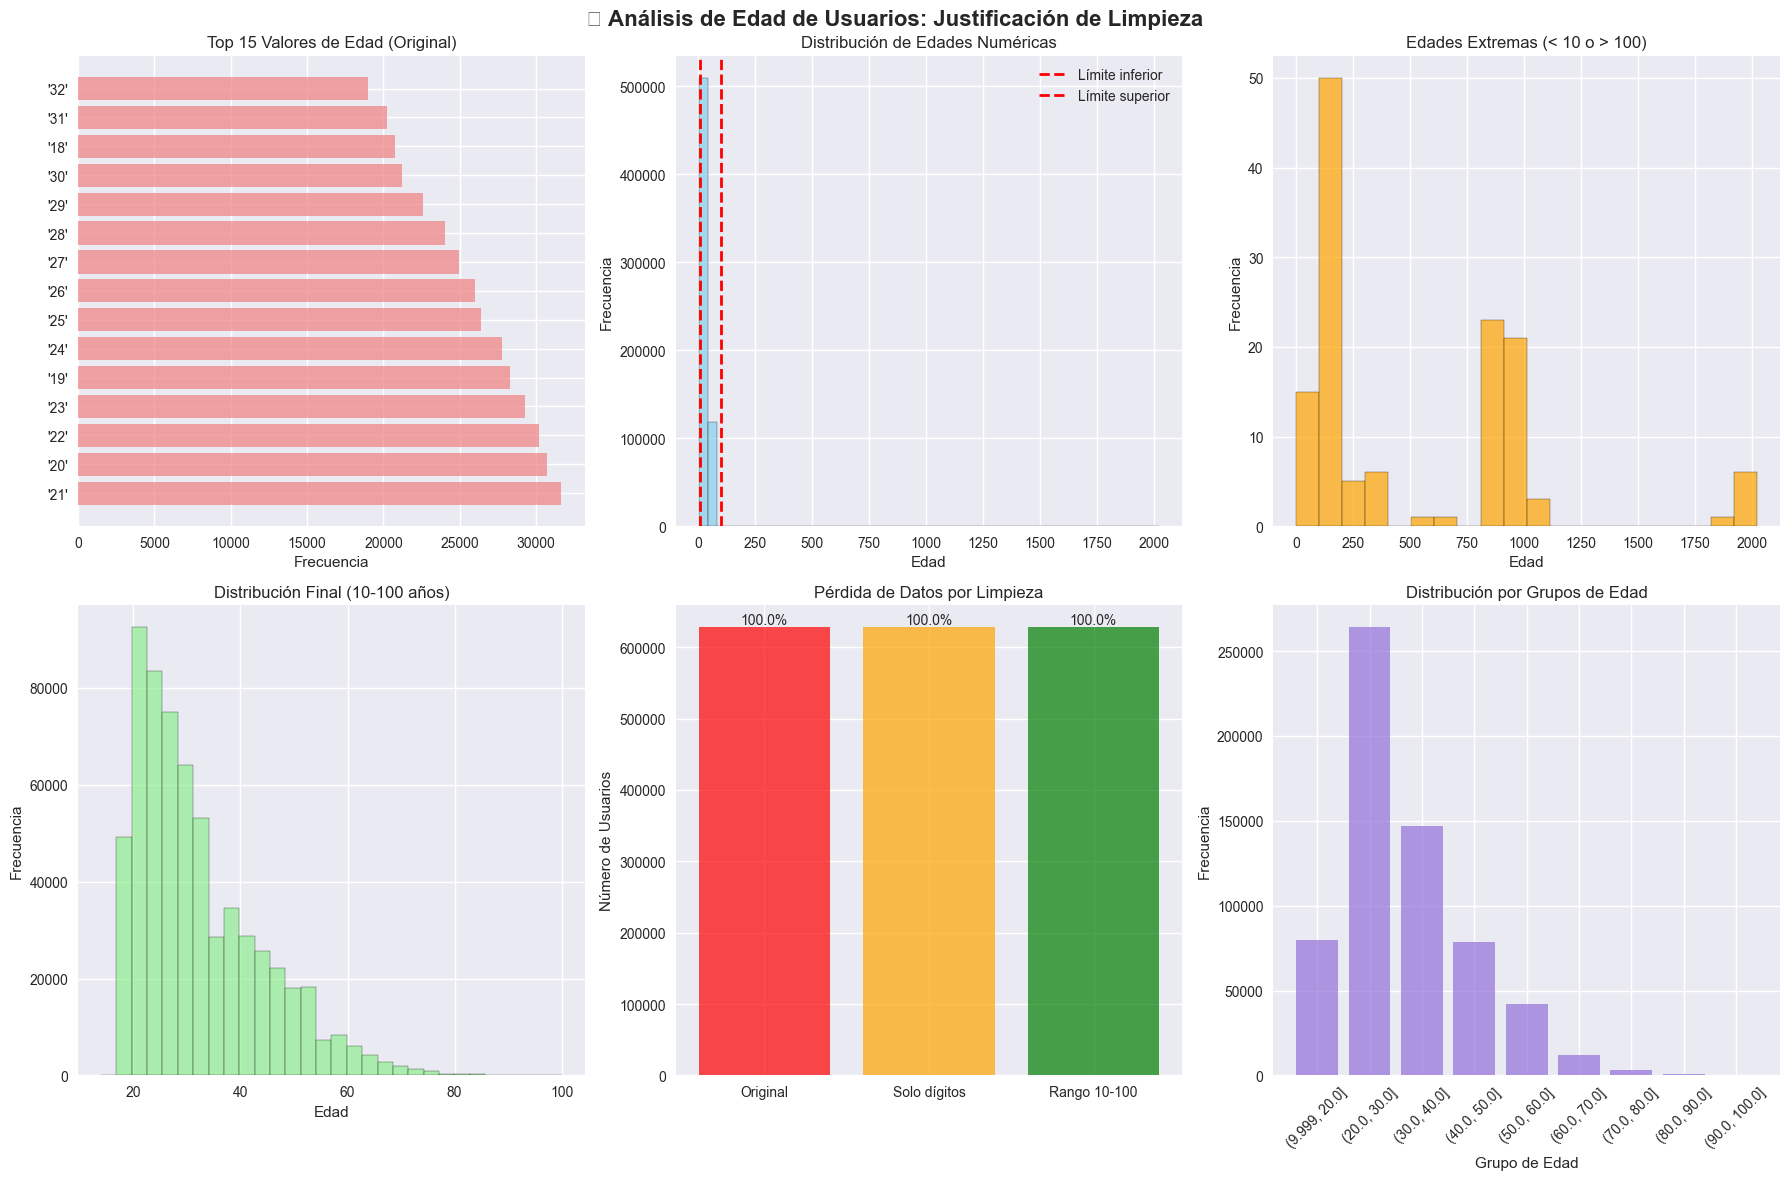


📊 ESTADÍSTICAS DE EDAD:
• Total usuarios originales: 627,881
• Usuarios con valores que son dígitos: 627,872 (100.0%)
• Usuarios con edad 10-100: 627,740 (100.0%)

🔍 TOP 10 VALORES NO NUMÉRICOS:
  '-38': 2 usuarios
  '-42': 2 usuarios
  '-21': 1 usuarios
  '-940': 1 usuarios
  '-976': 1 usuarios
  '-947': 1 usuarios
  '-45': 1 usuarios

⚠️ EDADES EXTREMAS:
• Edades < 10: 13
• Edades > 100: 119
• Edad mínima: 2
• Edad máxima: 2023

💡 JUSTIFICACIÓN FILTRO 10-100:
• Eliminar 141 registros problemáticos (0.0% del total)
• Valores no numéricos probablemente son errores de entrada
• Edades < 10 o > 100 son biológicamente improbables para usuarios de bicicletas
• Edad promedio final: 32.2 años
• Edad mediana final: 29.0 años


In [10]:
# Análisis de distribución de edades
if usuarios is not None and edad_col:
    
    # Aplicar limpieza como en el código original
    usuarios_clean = usuarios.copy()
    usuarios_clean[edad_col] = usuarios_clean[edad_col].astype(str)
    usuarios_clean[edad_col] = usuarios_clean[edad_col].str.replace(',', '', regex=False).str.strip()
    
    # Separar datos antes y después de limpieza
    original_data = usuarios[edad_col].astype(str)
    
    # Identificar valores que son dígitos
    is_digit = usuarios_clean[edad_col].str.isdigit()
    numeric_ages = usuarios_clean[is_digit][edad_col].astype(int)
    
    # Filtrar por rango 10-100
    valid_ages = numeric_ages[(numeric_ages >= 10) & (numeric_ages <= 100)]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('👥 Análisis de Edad de Usuarios: Justificación de Limpieza', fontsize=16, fontweight='bold')
    
    # 1. Valores únicos más frecuentes (original)
    top_values = original_data.value_counts().head(15)
    axes[0,0].barh(range(len(top_values)), top_values.values, color='lightcoral', alpha=0.7)
    axes[0,0].set_yticks(range(len(top_values)))
    axes[0,0].set_yticklabels([f"'{val}'" for val in top_values.index])
    axes[0,0].set_title('Top 15 Valores de Edad (Original)')
    axes[0,0].set_xlabel('Frecuencia')
    
    # 2. Distribución de edades numéricas válidas
    axes[0,1].hist(numeric_ages, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].set_title('Distribución de Edades Numéricas')
    axes[0,1].set_xlabel('Edad')
    axes[0,1].set_ylabel('Frecuencia')
    axes[0,1].axvline(10, color='red', linestyle='--', linewidth=2, label='Límite inferior')
    axes[0,1].axvline(100, color='red', linestyle='--', linewidth=2, label='Límite superior')
    axes[0,1].legend()
    
    # 3. Zoom en edades extremas
    extreme_ages = numeric_ages[(numeric_ages < 10) | (numeric_ages > 100)]
    if len(extreme_ages) > 0:
        axes[0,2].hist(extreme_ages, bins=20, alpha=0.7, color='orange', edgecolor='black')
        axes[0,2].set_title('Edades Extremas (< 10 o > 100)')
        axes[0,2].set_xlabel('Edad')
        axes[0,2].set_ylabel('Frecuencia')
    else:
        axes[0,2].text(0.5, 0.5, 'No hay edades extremas', ha='center', va='center', transform=axes[0,2].transAxes)
        axes[0,2].set_title('Edades Extremas (< 10 o > 100)')
    
    # 4. Distribución final (10-100 años)
    axes[1,0].hist(valid_ages, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,0].set_title('Distribución Final (10-100 años)')
    axes[1,0].set_xlabel('Edad')
    axes[1,0].set_ylabel('Frecuencia')
    
    # 5. Comparación de pérdida de datos
    categories = ['Original', 'Solo dígitos', 'Rango 10-100']
    counts = [len(usuarios), len(numeric_ages), len(valid_ages)]
    percentages = [100, len(numeric_ages)/len(usuarios)*100, len(valid_ages)/len(usuarios)*100]
    
    bars = axes[1,1].bar(categories, counts, alpha=0.7, color=['red', 'orange', 'green'])
    axes[1,1].set_title('Pérdida de Datos por Limpieza')
    axes[1,1].set_ylabel('Número de Usuarios')
    
    # Añadir porcentajes en las barras
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{pct:.1f}%', ha='center', va='bottom')
    
    # 6. Estadísticas por grupo de edad
    age_groups = pd.cut(valid_ages, bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], include_lowest=True)
    group_counts = age_groups.value_counts().sort_index()
    
    axes[1,2].bar(range(len(group_counts)), group_counts.values, alpha=0.7, color='mediumpurple')
    axes[1,2].set_title('Distribución por Grupos de Edad')
    axes[1,2].set_xlabel('Grupo de Edad')
    axes[1,2].set_ylabel('Frecuencia')
    axes[1,2].set_xticks(range(len(group_counts)))
    axes[1,2].set_xticklabels([str(interval) for interval in group_counts.index], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas detalladas
    print("\n📊 ESTADÍSTICAS DE EDAD:")
    print(f"• Total usuarios originales: {len(usuarios):,}")
    print(f"• Usuarios con valores que son dígitos: {len(numeric_ages):,} ({len(numeric_ages)/len(usuarios)*100:.1f}%)")
    print(f"• Usuarios con edad 10-100: {len(valid_ages):,} ({len(valid_ages)/len(usuarios)*100:.1f}%)")
    
    # Análisis de valores problemáticos
    non_digit = usuarios_clean[~is_digit][edad_col].value_counts().head(10)
    print(f"\n🔍 TOP 10 VALORES NO NUMÉRICOS:")
    for val, count in non_digit.items():
        print(f"  '{val}': {count:,} usuarios")
    
    if len(extreme_ages) > 0:
        print(f"\n⚠️ EDADES EXTREMAS:")
        print(f"• Edades < 10: {len(numeric_ages[numeric_ages < 10]):,}")
        print(f"• Edades > 100: {len(numeric_ages[numeric_ages > 100]):,}")
        print(f"• Edad mínima: {numeric_ages.min()}")
        print(f"• Edad máxima: {numeric_ages.max()}")
    
    print(f"\n💡 JUSTIFICACIÓN FILTRO 10-100:")
    eliminated = len(usuarios) - len(valid_ages)
    print(f"• Eliminar {eliminated:,} registros problemáticos ({eliminated/len(usuarios)*100:.1f}% del total)")
    print(f"• Valores no numéricos probablemente son errores de entrada")
    print(f"• Edades < 10 o > 100 son biológicamente improbables para usuarios de bicicletas")
    print(f"• Edad promedio final: {valid_ages.mean():.1f} años")
    print(f"• Edad mediana final: {valid_ages.median():.1f} años")


In [11]:
# Análisis de coordenadas e IDs
if datasets:
    # Usar una muestra para análisis rápido
    sample_df = list(datasets.values())[0].head(100000)  # Primer dataset, 100k registros
    
    print("🔍 ANÁLISIS DE CALIDAD DE DATOS:")
    print(f"• Muestra analizada: {len(sample_df):,} registros")
    
    # Analizar IDs faltantes
    id_cols = ['id_estacion_origen', 'id_estacion_destino', 'id_recorrido', 'id_usuario']
    coord_cols = ['lat_estacion_origen', 'long_estacion_origen', 'lat_estacion_destino', 'long_estacion_destino']
    
    print("\n📊 VALORES FALTANTES POR COLUMNA:")
    for col in id_cols + coord_cols:
        if col in sample_df.columns:
            missing = sample_df[col].isna().sum()
            missing_pct = missing / len(sample_df) * 100
            print(f"• {col}: {missing:,} ({missing_pct:.1f}%)")
        else:
            print(f"• {col}: No encontrada")
    
    # Analizar coordenadas válidas (rango Buenos Aires)
    if 'lat_estacion_origen' in sample_df.columns:
        lat_col = 'lat_estacion_origen'
        lon_col = 'long_estacion_origen'
        
        # Convertir a numérico si es necesario
        sample_df[lat_col] = pd.to_numeric(sample_df[lat_col], errors='coerce')
        sample_df[lon_col] = pd.to_numeric(sample_df[lon_col], errors='coerce')
        
        # Rangos aproximados de Buenos Aires
        lat_min, lat_max = -34.8, -34.5
        lon_min, lon_max = -58.7, -58.3
        
        valid_coords = sample_df[
            (sample_df[lat_col].between(lat_min, lat_max)) & 
            (sample_df[lon_col].between(lon_min, lon_max)) &
            (sample_df[lat_col].notna()) & 
            (sample_df[lon_col].notna())
        ]
        
        print(f"\n🗺️ ANÁLISIS DE COORDENADAS:")
        print(f"• Coordenadas válidas (rango Buenos Aires): {len(valid_coords):,} ({len(valid_coords)/len(sample_df)*100:.1f}%)")
        print(f"• Coordenadas fuera de rango o faltantes: {len(sample_df) - len(valid_coords):,}")
        
        if len(valid_coords) > 0:
            print(f"• Latitud rango: {valid_coords[lat_col].min():.3f} a {valid_coords[lat_col].max():.3f}")
            print(f"• Longitud rango: {valid_coords[lon_col].min():.3f} a {valid_coords[lon_col].max():.3f}")
    
    # Analizar patrones en IDs
    if 'id_estacion_origen' in sample_df.columns:
        id_col = 'id_estacion_origen'
        non_null_ids = sample_df[sample_df[id_col].notna()][id_col]
        
        print(f"\n🔖 ANÁLISIS DE IDs:")
        print(f"• IDs únicos de estación: {non_null_ids.nunique():,}")
        print(f"• Formato más común de ID: {non_null_ids.astype(str).str[:3].value_counts().head(1).index[0]}...")
        
        # Verificar si contienen 'BAEcobici'
        with_prefix = non_null_ids.astype(str).str.contains('BAEcobici', na=False).sum()
        print(f"• IDs con prefijo 'BAEcobici': {with_prefix:,} ({with_prefix/len(non_null_ids)*100:.1f}%)")
    
    print(f"\n💡 JUSTIFICACIONES:")
    print(f"• Registros sin ID de estación origen son inútiles para análisis geoespacial")
    print(f"• Coordenadas fuera del rango de Buenos Aires indican errores de datos")
    print(f"• Prefijos 'BAEcobici' son redundantes y deben limpiarse")
    print(f"• IDs faltantes impiden hacer joins con datos de estaciones")


🔍 ANÁLISIS DE CALIDAD DE DATOS:
• Muestra analizada: 100,000 registros

📊 VALORES FALTANTES POR COLUMNA:
• id_estacion_origen: 0 (0.0%)
• id_estacion_destino: 3 (0.0%)
• id_recorrido: No encontrada
• id_usuario: 0 (0.0%)
• lat_estacion_origen: 0 (0.0%)
• long_estacion_origen: 0 (0.0%)
• lat_estacion_destino: 3 (0.0%)
• long_estacion_destino: 3 (0.0%)

🗺️ ANÁLISIS DE COORDENADAS:
• Coordenadas válidas (rango Buenos Aires): 100,000 (100.0%)
• Coordenadas fuera de rango o faltantes: 0
• Latitud rango: -34.683 a -34.542
• Longitud rango: -58.520 a -58.355

🔖 ANÁLISIS DE IDs:
• IDs únicos de estación: 397
• Formato más común de ID: 175...
• IDs con prefijo 'BAEcobici': 100,000 (100.0%)

💡 JUSTIFICACIONES:
• Registros sin ID de estación origen son inútiles para análisis geoespacial
• Coordenadas fuera del rango de Buenos Aires indican errores de datos
• Prefijos 'BAEcobici' son redundantes y deben limpiarse
• IDs faltantes impiden hacer joins con datos de estaciones


In [12]:
# Resumen final comparativo
print("=" * 80)
print("🎯 RESUMEN EJECUTIVO: IMPACTO DE LA LIMPIEZA DE DATOS")
print("=" * 80)

if datasets:
    # Simular aplicación de filtros (usando una muestra)
    sample_original = list(datasets.values())[0].head(50000)
    
    print(f"\n📊 DATASET ORIGINAL (muestra):")
    print(f"• Registros totales: {len(sample_original):,}")
    
    # Simular filtros de duración
    sample_original['duracion_recorrido'] = pd.to_numeric(
        sample_original['duracion_recorrido'].astype(str).str.replace(',', ''), 
        errors='coerce'
    )
    
    after_duration = sample_original[sample_original['duracion_recorrido'] >= 60]
    after_ids = after_duration.dropna(subset=['id_estacion_origen'])
    
    print(f"\n🔍 DESPUÉS DE LIMPIEZA:")
    print(f"• Después filtro duración (≥60s): {len(after_duration):,} ({len(after_duration)/len(sample_original)*100:.1f}%)")
    print(f"• Después filtro IDs válidos: {len(after_ids):,} ({len(after_ids)/len(sample_original)*100:.1f}%)")
    
    eliminated = len(sample_original) - len(after_ids)
    print(f"\n📉 REGISTROS ELIMINADOS:")
    print(f"• Total eliminado: {eliminated:,} ({eliminated/len(sample_original)*100:.1f}%)")
    print(f"• Por duración < 60s: {len(sample_original) - len(after_duration):,}")
    print(f"• Por IDs faltantes: {len(after_duration) - len(after_ids):,}")

print(f"\n✅ BENEFICIOS OBTENIDOS:")
print(f"• Dataset más confiable para machine learning")
print(f"• Eliminación de outliers y errores sistemáticos") 
print(f"• Consistencia temporal y geográfica")
print(f"• Mejor calidad para análisis predictivo")

print(f"\n🚀 PRÓXIMOS PASOS:")
print(f"• Ejecutar src/utils.py para aplicar limpieza completa")
print(f"• Validar resultados con dataset completo")
print(f"• Proceder con feature engineering")
print(f"• Entrenar modelos con datos limpios")

print("\n" + "=" * 80)
print("📋 Análisis completado. Dataset listo para machine learning.")
print("=" * 80)


🎯 RESUMEN EJECUTIVO: IMPACTO DE LA LIMPIEZA DE DATOS

📊 DATASET ORIGINAL (muestra):
• Registros totales: 50,000

🔍 DESPUÉS DE LIMPIEZA:
• Después filtro duración (≥60s): 50,000 (100.0%)
• Después filtro IDs válidos: 50,000 (100.0%)

📉 REGISTROS ELIMINADOS:
• Total eliminado: 0 (0.0%)
• Por duración < 60s: 0
• Por IDs faltantes: 0

✅ BENEFICIOS OBTENIDOS:
• Dataset más confiable para machine learning
• Eliminación de outliers y errores sistemáticos
• Consistencia temporal y geográfica
• Mejor calidad para análisis predictivo

🚀 PRÓXIMOS PASOS:
• Ejecutar src/utils.py para aplicar limpieza completa
• Validar resultados con dataset completo
• Proceder con feature engineering
• Entrenar modelos con datos limpios

📋 Análisis completado. Dataset listo para machine learning.
